# 그래프를 실행하는 다양한 방법

## Graph 정의

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import (
    HumanMessage,
    AIMessage,
    AnyMessage
)
from langgraph.graph.message import add_messages

class InputState(TypedDict):
    query: str

class OutputState(TypedDict):
    answer: str

class GraphState(InputState, OutputState):
    messages: Annotated[list[AnyMessage], add_messages]

In [22]:
def chatbot_1(state: InputState):
    query = state['query']
    user_message = HumanMessage(content=query)

    answer = "안녕하세요! 저는 챗봇 1 입니다."
    ai_message = AIMessage(content=answer)

    return {
        "messages" : [user_message, ai_message],
        "answer" : answer
    }

def chatbot_2(state: GraphState):
    answer = "안녕하세요! 저는 챗봇 2 입니다."
    ai_message = AIMessage(content=answer)

    return {
        "messages" : [ai_message],
        "answer" : answer
    }

def chatbot_3(state: GraphState):
    answer = "안녕하세요! 저는 챗봇 3 입니다."
    ai_message = AIMessage(content=answer)

    return {
        "messages" : [ai_message],
        "answer" : answer
    }

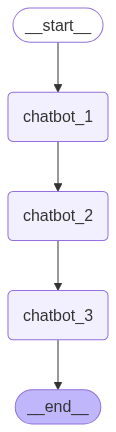

In [23]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(
    GraphState,
    input=InputState,
    output=OutputState
)

workflow.add_node("chatbot_1", chatbot_1)
workflow.add_node("chatbot_2", chatbot_2)
workflow.add_node("chatbot_3", chatbot_3)

workflow.add_edge(START, "chatbot_1")
workflow.add_edge("chatbot_1", "chatbot_2")
workflow.add_edge("chatbot_2", "chatbot_3")
workflow.add_edge("chatbot_3", END)

app = workflow.compile()

app

## `.invoke()`

> 하나의 요청에 대한 결과를 받을 때 까지 코드 실행 멈춤. 즉, 한번에 하나의 요청 처리

In [24]:
app.invoke({"query" : "안녕"})

{'answer': '안녕하세요! 저는 챗봇 3 입니다.'}

## `.ainvoke()`

> 비동기 처리 함수. 한번에 여러 요청을 보낼 수 있음

In [25]:
await app.ainvoke({"query" : "안녕"})

{'answer': '안녕하세요! 저는 챗봇 3 입니다.'}

## `.stream()`

> 중간 결과를 실시간으로 반환

### `stream_mode="values"`

> 각 단계의 현재 state 값 출력
- chunk의 key와 value는 각 단계(노드)마다의 state의 key, state의 value 임

In [26]:
for chunk in app.stream({"query" : "안녕"}, stream_mode="values"):
    print(chunk)
    for state_key, state_value in chunk.items():
        if state_key == "messages":
            if len(state_value) == 0:
                HumanMessage(content="안녕").pretty_print()
            else:
                state_value[-1].pretty_print()
    print("\n\n")

{'query': '안녕', 'messages': []}
================================ Human Message =================================

안녕



{'query': '안녕', 'answer': '안녕하세요! 저는 챗봇 1 입니다.', 'messages': [HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}, id='53c6376b-ba78-4af7-ac8a-fbf5657a7b72'), AIMessage(content='안녕하세요! 저는 챗봇 1 입니다.', additional_kwargs={}, response_metadata={}, id='58fdf4e0-f147-4ad9-a1ee-b2eaad6c07d4')]}
================================== Ai Message ==================================

안녕하세요! 저는 챗봇 1 입니다.



{'query': '안녕', 'answer': '안녕하세요! 저는 챗봇 2 입니다.', 'messages': [HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}, id='53c6376b-ba78-4af7-ac8a-fbf5657a7b72'), AIMessage(content='안녕하세요! 저는 챗봇 1 입니다.', additional_kwargs={}, response_metadata={}, id='58fdf4e0-f147-4ad9-a1ee-b2eaad6c07d4'), AIMessage(content='안녕하세요! 저는 챗봇 2 입니다.', additional_kwargs={}, response_metadata={}, id='5b648226-2110-4f7a-83b1-af59f122d28b')]}
================================

### `stream_mode="updates"` (default)

> 각 단계에서 업데이트된 state 값만 출력

chunk의 key와 value는 `노드의 이름` 과 `해당 노드에서 업데이트 된 값` 임

In [27]:
for chunk in app.stream({"query" : "안녕"}, stream_mode="updates"):
    # print(chunk)
    for node_name, update_value in chunk.items():
        print(node_name)
        if ('messages' in update_value) and (len(update_value['messages']) > 0):
            print(update_value['messages'])
        print("\n\n")

chatbot_1
[HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}, id='4aaec10c-4977-4dd6-894c-852aa7620c9e'), AIMessage(content='안녕하세요! 저는 챗봇 1 입니다.', additional_kwargs={}, response_metadata={}, id='7ff10435-37e6-48d8-8476-32a44884792e')]



chatbot_2
[AIMessage(content='안녕하세요! 저는 챗봇 2 입니다.', additional_kwargs={}, response_metadata={}, id='4bde741f-ab15-4dad-9c5a-8e4ddfda8580')]



chatbot_3
[AIMessage(content='안녕하세요! 저는 챗봇 3 입니다.', additional_kwargs={}, response_metadata={}, id='766bdc6f-3ae8-4e70-b86d-e3e4a84d817a')]





### `stream_mode="message"`

> 각 단계의 메시지를 출력
- 메시지
- 메타데이터
위의 두가지를 key와 value로 제공

In [28]:
for chunk_msg, metadata in app.stream({'query' : "안녕"}, stream_mode="messages"):
    print(chunk_msg.content)
    print(metadata)
    print("\n\n")

안녕
{'langgraph_step': 1, 'langgraph_node': 'chatbot_1', 'langgraph_triggers': ('branch:to:chatbot_1',), 'langgraph_path': ('__pregel_pull', 'chatbot_1'), 'langgraph_checkpoint_ns': 'chatbot_1:80a5e8cc-0205-3836-9161-1792df548352'}



안녕하세요! 저는 챗봇 1 입니다.
{'langgraph_step': 1, 'langgraph_node': 'chatbot_1', 'langgraph_triggers': ('branch:to:chatbot_1',), 'langgraph_path': ('__pregel_pull', 'chatbot_1'), 'langgraph_checkpoint_ns': 'chatbot_1:80a5e8cc-0205-3836-9161-1792df548352'}



안녕하세요! 저는 챗봇 2 입니다.
{'langgraph_step': 2, 'langgraph_node': 'chatbot_2', 'langgraph_triggers': ('branch:to:chatbot_2',), 'langgraph_path': ('__pregel_pull', 'chatbot_2'), 'langgraph_checkpoint_ns': 'chatbot_2:431e1732-3b13-5e70-5514-faf0ec93b9da'}



안녕하세요! 저는 챗봇 3 입니다.
{'langgraph_step': 3, 'langgraph_node': 'chatbot_3', 'langgraph_triggers': ('branch:to:chatbot_3',), 'langgraph_path': ('__pregel_pull', 'chatbot_3'), 'langgraph_checkpoint_ns': 'chatbot_3:81106643-b9ae-8542-07b9-b3e0da24cdc7'}



